In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Implementing a Perceptron Learning Algorithm in Python 

## Perceptron Key Hyperparameters
| Hyperparameter     | Description                                                        | Common Values / Notes                                    |
| ------------------ | ------------------------------------------------------------------ | -------------------------------------------------------- |
| `penalty`          | Regularization method                                              | `None` (default), `'l2'`, `'l1'`, `'elasticnet'`         |
| `alpha`            | Regularization strength (used with penalty)                        | Default: `0.0001`, try `1e-4`, `1e-3`, `1e-2`            |
| `fit_intercept`    | Whether to calculate the intercept for the model                   | `True` (default) or `False`                              |
| `max_iter`         | Maximum number of passes over the training data                    | Default: `1000`, try `100`, `500`, `1000`                |
| `tol`              | Tolerance for stopping criterion                                   | Default: `1e-3`, lower = stricter convergence            |
| `shuffle`          | Whether to shuffle data each epoch                                 | `True` (default)                                         |
| `eta0`             | Initial learning rate                                              | Default: `1.0`, try `0.01`, `0.1`, `0.5`                 |
| `early_stopping`   | Stop training early if validation score does not improve           | `False` (default), set `True` with `validation_fraction` |
| `n_iter_no_change` | Number of iterations with no improvement to trigger early stopping | Default: `5`                                             |
| `random_state`     | Controls shuffling and reproducibility                             | Use an integer like `42`                                 |
| `class_weight`     | Handle imbalanced data                                             | `None` or `'balanced'`                                   |


In [79]:
class Perceptron:

    def __init__(self, eta=0.01, n_iter=50, random_state=42):
        # initialized the perceptron with learning_rate, no of iterations and random seed
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, x, y):

        # Initialize random number generator for reproduciblity
        rgen = np.random.RandomState(self.random_state)

        # Initize weights with small random values
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=x.shape[1])

        # Initialize bias as 0
        self.b_ = np.float_(0.)

        # Initialize a list to track the number of errors in each epoch
        self.errors_ = []

        # Iterate through the training data for 'n_iter' epochs
        for _ in range(self.n_iter):
            errors = 0
            # Update weights and bias for each training example
            for xi, target in zip(x,y):
                # calculate weight update on prediction error
                update = self.eta * (target - self.predict(xi))

                # update weights and bias
                self.w_ += update*xi
                self.b_ += update
                
                # count misclassification
                errors += int(update !=0.0)

               
            # store the error count for this epoch
            self.errors_.append(errors)

        return self


    def net_input (self, x):
        """Calculate net input"""
    # calculate the weighted sum (dot product) of inputs + bias
    # z = w.x + b
        return np.dot(x, self.w_) + self.b_


    def predict(self, x):
        """Return Class Label after Unit Step"""
        # Apply step function to the net input to make a prediction (0 or 1)
        return np.where(self.net_input(x) >= 0.0, 1, 0)
            

# Training a Perceptron Model on the Iris Dataset

In [80]:
from sklearn.datasets import load_iris

In [81]:

# Load dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[i] for i in iris.target]

# Binary classification: 'setosa' vs not-setosa
df['target'] = (df['species'] == 'setosa').astype(int)

# Separate features and labels
x = df.drop(['species', 'target'], axis=1).astype(float)  # Ensure float dtype
y = df['target'].astype(int)

In [82]:
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [83]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [84]:
y.unique()

array([1, 0])

In [85]:
x.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
dtype: object

# Training the Perceptron Model

In [86]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(x.values,y.values)


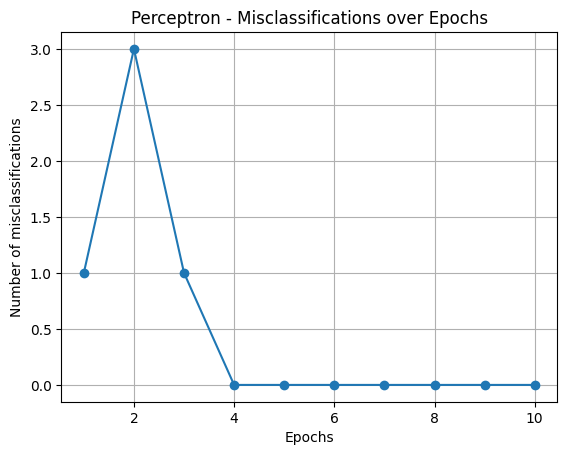

In [87]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.title('Perceptron - Misclassifications over Epochs')
plt.grid(True)
plt.show()


In [88]:
from sklearn.metrics import accuracy_score

y_pred = ppn.predict(x.values)
print("Accuracy:", accuracy_score(y, y_pred))


Accuracy: 1.0


# Adaptive Linear Neuron and the Convergence of Learning
## Minimizing cost functions with gradient decent

# Common Parameters for Adaline
| Parameter      | Description                                                   |
| -------------- | ------------------------------------------------------------- |
| `eta`          | Learning rate (e.g., `0.01`)                                  |
| `n_iter`       | Number of passes (epochs) over the training dataset           |
| `random_state` | Seed for reproducible weight initialization                   |
| `shuffle`      | Whether to shuffle training data each epoch (for SGD variant) |
| `batch`        | Whether to use batch gradient descent or stochastic (SGD)     |


In [89]:
class AdalineGD:
    """Adaptive Linear Nueron  Classifier"""


    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, x,y):
        # Initialize random number generator for reproduciblity
        rgen = np.random.RandomState(self.random_state)

        # Initize weights with small random values
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=x.shape[1])

        # Initialize bias as 0
        self.b_ = np.float_(0.)

        # Initialize a list to track the number of errors in each epoch
        self.losses_ = []

         # Iterate through the training data for 'n_iter' epochs
        for i in range(self.n_iter):
            # Calculate the net input
            net_input = self.net_input(x)

            # Activation Funtion is identify (linear) in Adaline
            output = self.activation(net_input)

            # Calculate the errors(diffrence between the target and output)
            errors = (y - output)
            
            # Update weights using gradient decent formula
            self.w_ += self.eta * 2.0 * x.T.dot(errors) / x.shape[0]

            # Update bias using the gradient decent formula
            self.b_ += self.eta * 2.0 * errors.mean()
                
            # Calculate & store the mean squared error loss for current epoch
            loss = (errors**2).mean()
            self.losses_.append(loss)

        return self


    def net_input(self, x):
        # calculate the weighted sum (dot product) of input + bias
        return np.dot(x, self.w_)+self.b_

    
    def activation(self, x):
        # In adaline activation is just a identity function (No Transformation)
        return x


    def predict(self, x):
        # Apply the activation function to the net input and return class labels (0,1)
        return np.where(self.activation(self.net_input(x)) >= 0.5, 1, 0)

In [90]:
ada1 = AdalineGD(eta=0.1, n_iter=10).fit(x,y)

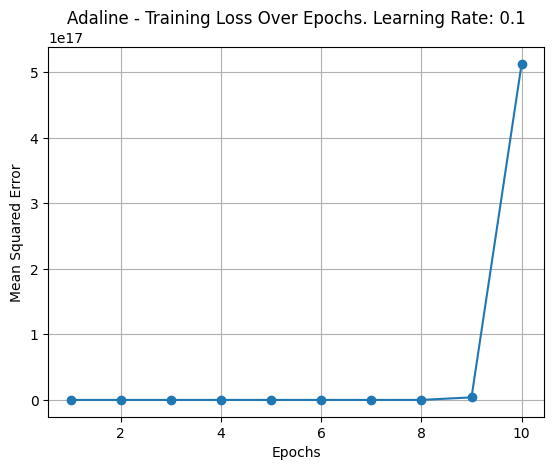

In [91]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Adaline - Training Loss Over Epochs. Learning Rate: 0.1')
plt.grid(True)
plt.show()

/tmp/ipykernel_35/2111881999.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


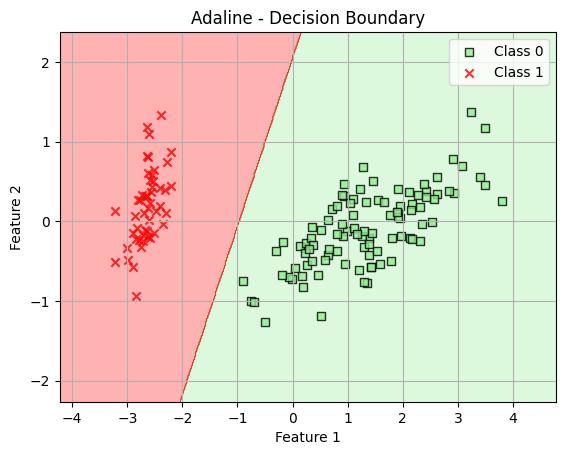

In [92]:
import numpy as np

def plot_decision_regions(X, y, classifier, resolution=0.02):
    from matplotlib.colors import ListedColormap

    # Setup marker generator and color map
    markers = ('s', 'x')
    colors = ('lightgreen', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Adaline - Decision Boundary')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage (only works for 2D):
# plot_decision_regions(x, y, classifier=ada1)
from sklearn.decomposition import PCA
x_pca = PCA(n_components=2).fit_transform(x)
ada1.fit(x_pca, y)
plot_decision_regions(x_pca, y, classifier=ada1)



In [93]:
ada2 = AdalineGD(eta=0.001, n_iter=10).fit(x,y)

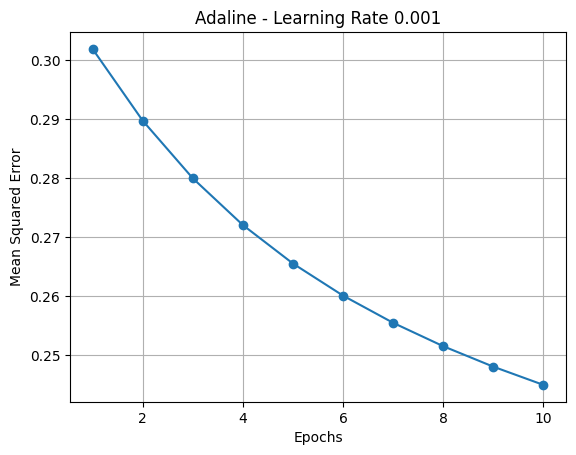

In [94]:
plt.plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Adaline - Learning Rate 0.001')
plt.grid(True)
plt.show()


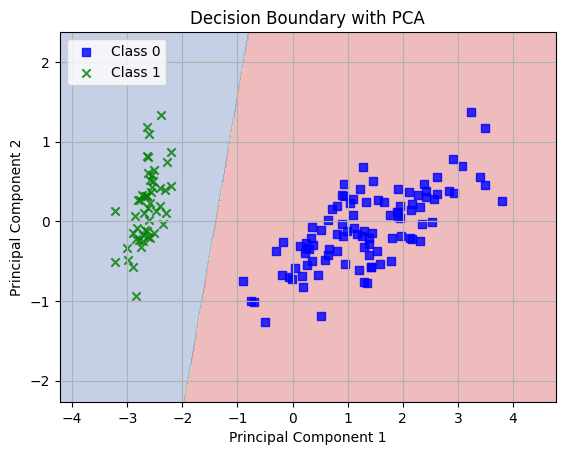

In [95]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Reduce to 2D using PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)  # x should be your full dataset

# Step 2: Re-train classifier on PCA-transformed data
ada_pca = AdalineGD(eta=0.01, n_iter=50).fit(x_pca, y)

# Step 3: Define decision boundary plot function
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x')
    colors = ('blue', 'green')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    grid_points = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = classifier.predict(grid_points)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Decision Boundary with PCA')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Step 4: Plot decision regions
plot_decision_regions(x_pca, y, classifier=ada_pca)


# Large Scale Machine Learning & Stochastic Gradient Decent 

In [96]:
import numpy as np

class AdalineSGD:
    """ADAptive LInear NEuron classifier using Stochastic Gradient Descent (SGD).

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        # Initialize hyperparameters: learning rate, number of iterations, shuffle flag, and random seed
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object
        """
        
        # Initialize weights before training
        self._initialize_weights(X.shape[1])
        
        # List to store loss values during training
        self.losses_ = []
        
        # Loop over the specified number of iterations (epochs)
        for i in range(self.n_iter):
            # Shuffle training data if 'shuffle' flag is True
            if self.shuffle:
                X, y = self._shuffle(X, y)
                
            # List to store losses for the current epoch
            losses = []
            
            # Loop over each training example
            for xi, target in zip(X, y):
                # Update weights and calculate loss for each example
                losses.append(self._update_weights(xi, target))
                
            # Calculate the average loss for the epoch
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        
        # If there are multiple examples, update weights for each example
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            # Update weights for a single example
            self._update_weights(X, y)
        
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        # Shuffle the training data and return the shuffled version
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        # Set random seed and initialize weights and bias
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)  # Random initialization of weights
        self.b_ = np.float_(0.)  # Initialize bias to 0
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        # Calculate the predicted output based on the current weights and bias
        output = self.activation(self.net_input(xi))
        
        # Calculate the error between the predicted output and target value
        error = (target - output)
        
        # Update weights and bias using the Adaline learning rule (SGD)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        
        # Return the squared error as the loss
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        # Compute the weighted sum of the inputs plus the bias term
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        # In Adaline, activation is just the identity (linear) function
        return X

    def predict(self, X):
        """Return class label after unit step"""
        # Predict class labels based on the activation function
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


In [97]:
x = x.to_numpy()  # only do this if you're done using x as a DataFrame
X_std = np.copy(x)
X_std[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()
X_std[:, 1] = (x[:, 1] - x[:, 1].mean()) / x[:, 1].std()


In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Standardize your features (assuming x is a DataFrame or 2D array)
X_std = (x - x.mean(axis=0)) / x.std(axis=0)

# Train AdalineSGD on standardized data
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

# Plot decision boundary
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Feature 1 [standardized]')
plt.ylabel('Feature 2 [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Plot loss over epochs
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Adaline SGD - Learning Progress')
plt.tight_layout()
plt.show()


ValueError: shapes (120263,2) and (4,) not aligned: 2 (dim 1) != 4 (dim 0)

/tmp/ipykernel_35/1532708245.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


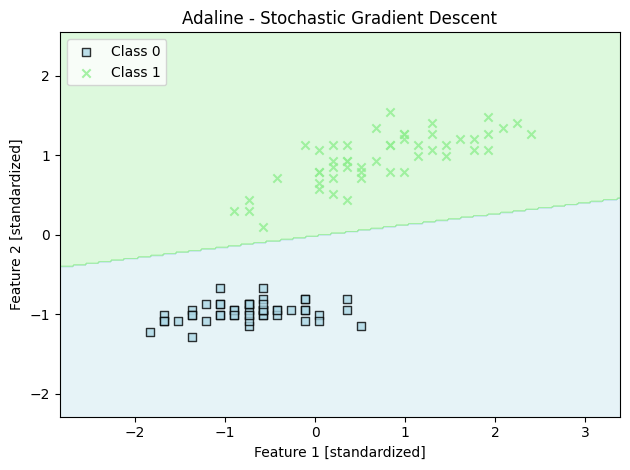

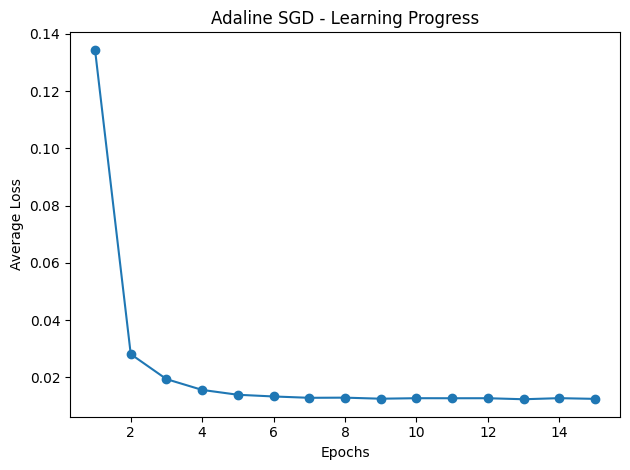

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Step 1: Plotting function for decision boundary
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('lightblue', 'lightgreen', 'gray', 'cyan', 'orange')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

# Step 2: AdalineSGD Class
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.w_initialized = False

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        return error**2

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

# Step 3: Data Preparation
# Sample: using sklearn iris for reproducibility
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, [0, 2]]  # sepal length and petal length
y = iris.target

# Binary classification for Adaline (setosa vs versicolor)
X = X[y != 2]
y = y[y != 2]

# Step 4: Standardize
X_std = (X - X.mean(axis=0)) / X.std(axis=0)

# Step 5: Train AdalineSGD
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

# Step 6: Plot Decision Boundary
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Feature 1 [standardized]')
plt.ylabel('Feature 2 [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Step 7: Plot Loss
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Adaline SGD - Learning Progress')
plt.tight_layout()
plt.show()
